In [ ]:
#path
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
#path_dataset = '/content/gdrive/MyDrive/Doutorado/Bases/GAMMA_training_data/multi-modality_images/'
path_dataset = '/content/gdrive/My Drive/Doutorado/Bases/GAMMA_val_data/multi-modality_images/'
os.chdir(path_dataset)

Mounted at /content/gdrive


# Plot Image with mask

In [ ]:
import cv2
import argparse
import matplotlib.pyplot as plt
import numpy as np
import csv
from pathlib import Path
#ap = argparse.ArgumentParser()
#ap.add_argument ("-i", "--image = fundus_images/0101.jpg", required=True, help="path to input image")
#ap.add_argument ("-c", "--connectivity", type=int, default=4, help="connectivity for connected component analysis")
#args = vars(ap.parse_args())
#ap.parse_args()

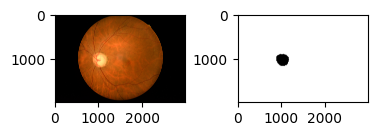

In [ ]:
path_image = ("fundus_images/0120.jpg")#validation
path_mask = ("Masks_DO_V4/0120.png")#validation

image = cv2.imread(path_image)
img_height, img_width, c = image.shape
image = cv2.resize(image,(img_width, img_height))
b,g,r = cv2.split(image)
image = cv2.merge([r,g,b])

mask = cv2.imread(path_mask)
image2 = mask
image2 = cv2.resize(image2,(img_width, img_height))

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)#Ajustando o layout do plot da imagem
ax = fig.add_subplot(1, 3, 1)#Imagem 1
ax.imshow(image)
ax = fig.add_subplot(1, 3, 2)#Imagem 2 (mask)
ax.imshow(image2)


# Test 1 image

In [ ]:
def calc_stats (mask, img_width, img_height):#return labels, num labels...
  mask = cv2.resize(mask, (img_width, img_height))
  gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  connectivity = 4
  thresh = cv2.threshold(gray, 0, 255,
	  cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output
  return numLabels, labels, stats, centroids

In [ ]:
# load the input image from disk, convert it to grayscale, and
# threshold it
path_image = ("fundus_images/0120.jpg")
path_mask = ("Masks_DO_V4/0120.png")

image = cv2.imread(path_image)
img_height, img_width, c = image.shape

b,g,r = cv2.split(image)
image = cv2.merge([r,g,b])
mask = cv2.imread(path_mask)

In [ ]:
from itertools import cycle
# loop over the number of unique connected component labels
def get_stats(numLabels, stats, centroids):
  for i in range(0, numLabels):
  #for i in range(0, 4):
    # if this is the first component then we examine the
    # *background* (typically we would just ignore this
    # component in our loop)
    if i == 0:
      text = "examining component {}/{} (background)".format(
        i + 1, numLabels)
    # otherwise, we are examining an actual connected component
    else:
      text = "examining component {}/{}".format( i + 1, numLabels)
    # print a status message update for the current connected
    # component
    #print("[INFO] {}".format(text))
    # extract the connected component statistics and centroid for
    # the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
  return x, y, w, h, cX, cY

In [ ]:
numLabels, labels, stats, centroids = calc_stats(mask, img_width, img_height)
x_1, y_1, w_1, h_1, cX_1, cY_1 = get_stats(numLabels, stats, centroids)
output = image.copy()
cv2.rectangle(output, (x_1, y_1), (x_1 + w_1, y_1 + h_1), (0, 255, 0), 25)
gap=50#pixel offset to crop
roi_cropped = image[int(y_1-gap):int(y_1+h_1+gap), int(x_1-gap):int(x_1+w_1+gap)]
#cv2.rectangle(output, (x_2, y_2), (x_2 + w_2, y_2 + h_2), (0, 255, 0), 5)
cv2.circle(output, (int(cX_1), int(cY_1)), 4, (0, 0, 255), -1)
# show our output image and connected component mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.axis('off')
ax2.axis('off')

ax1.imshow(output)
ax2.imshow(roi_cropped)

#imgplot = plt.imshow(output)
cv2.waitKey(0)

# Crop fundus images

Files list

In [ ]:

#train
folder_image = "/content/gdrive/MyDrive/Doutorado/Bases/GAMMA_training_data/multi-modality_images/dataset_fundus/train/fundus_images flip - 100 images/"
folder_mask = "/content/gdrive/MyDrive/Doutorado/Bases/GAMMA_training_data/multi-modality_images/dataset_fundus/train/Disc_Cup_Mask flip - 100 images/"

path_image = ("dataset_fundus/train/fundus_images 90 images/")
path_mask = ("dataset_fundus/train/Disc_Cup_Mask 90 images/")
batch_size = 2


train_ids = []

train_ids = sorted(os.listdir(folder_image))
train_ids = [i.split('.', 1)[0] for i in train_ids]#separate name (IDS) from suffix (.png)

# Crop ROIs


In [ ]:
show=0
gap=50
connectivity = 4
vODR = []#calculare vODR
from skimage.measure import label, regionprops
for id_name in train_ids:
  image = os.path.join(folder_image,"",id_name) + ".jpg"
  image = cv2.imread(image)
  #image = cv2.resize(image,(img_width, img_height))
  h, w, c = image.shape
  b,g,r = cv2.split(image)
  image = cv2.merge([r,g,b])

  mask = os.path.join(folder_mask,"",id_name) + ".png"
  mask = cv2.imread(mask)
  mask = cv2.resize(mask,(w,h))
  mask_1 = np.where(mask==128, 255, mask)
  mask_2 = mask

  numLabels, labels, stats, centroids = calc_stats(mask_1, w, h)
  x_1, y_1, w_1, h_1, cX_1, cY_1 = get_stats(numLabels, stats, centroids)#cup
  numLabels, labels, stats, centroids = calc_stats(mask_2, w, h)
  x_2, y_2, w_2, h_2, cX_2, cY_2 = get_stats(numLabels, stats, centroids)#disc
  r = (h_1)/(h_2)
  vODR.append(r)

  output = image.copy()
  cv2.rectangle(output, (x_1, y_1), (x_1 + w_1, y_1 + h_1), (255, 0, 0), 5)#cup
  cv2.rectangle(output, (x_2, y_2), (x_2 + w_2, y_2 + h_2), (0, 255, 0), 5)#disc

  roi_cropped = image[int(y_2-gap):int(y_2+h_2+gap), int(x_2-gap):int(x_2+w_2+gap)]

  cv2.circle(output, (int(cX_1), int(cY_1)), 4, (0, 0, 255), -1)
  nome_imagem = 'ROI_disco_50px/' + id_name + '.jpg'
  id = int(id_name)

  if show <= 10:#show x images
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
    ax1.imshow(image)
    ax2.imshow (mask)
    ax3.imshow(output)
    ax4.imshow(roi_cropped)

    ax1.set_title(id_name)
    ax2.set_title("Mask")
    ax3.set_title('Imagem com Bounding Box')
    ax4.set_title('ROI') #crop

  #save crops
  #b,g,r = cv2.split(roi_cropped)
  #roi_cropped = cv2.merge([r,g,b])
  #cv2.imwrite(nome_imagem, roi_cropped)
  show+=1